In [1]:
import sys
sys.path.append("../../SiMaC/")

In [2]:
import os
import string

import torch
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score

from src.dataset.toy import ToyDataset
from src.ml.model import SiMaC, SiMaCImplicit
from src.ml.layers import ScaledEmbedding
from src.ml.sinkhorn import SinkhornLoss, sinkhorn
from src.ml.train import assign_with_lap
from src import viz

In [3]:
sns.set(style="whitegrid", palette="Set2", font_scale=1.3)

In [4]:
%load_ext autoreload

In [5]:
FIG_SAVE_PATH = os.path.join("..", "paper", "figures")

In [6]:
%autoreload 2

## Dataset

In [7]:
n_centers = 3
n_items = 3
n_users = 1000
distance_weight = 0.3
n_features = 2

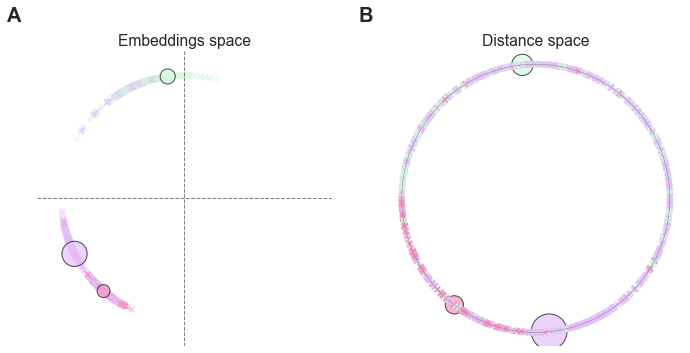

In [8]:
toy = ToyDataset(
    n_centers=n_centers,
    n_items=n_items,
    n_users=n_users,
    n_features=n_features,
    distance_weight=distance_weight
)

fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

# Embeddings space
viz.plot_embeddings(
    users_features=torch.from_numpy(toy.users_features),
    items_features=torch.from_numpy(toy.items_features),
    items_capacities=toy.items_capacities,
    y_pred=toy.assigned_item_for_user,
    ax=axs[0]
)

# Distance space
viz.plot_distances(
    np.asarray(list(zip(toy.users_x, toy.users_y))),
    np.asarray(list(zip(toy.items_x, toy.items_y))),
    toy.circle_radius,
    toy.assigned_item_for_user,
    toy.items_capacities,
    axs[1]
)

axs[0].set_title("Embeddings space")
axs[1].set_title("Distance space")

# Annotate with letters
for i in range(2):
    axs[i].text(-0.1, 1.1, string.ascii_uppercase[i],
                transform=axs[i].transAxes, 
                size=20, weight="bold")

plt.tight_layout()
plt.show()

## Training

In [9]:
target = torch.nn.functional.one_hot(
    torch.tensor(toy.assigned_item_for_user),
    num_classes=toy.n_items
)

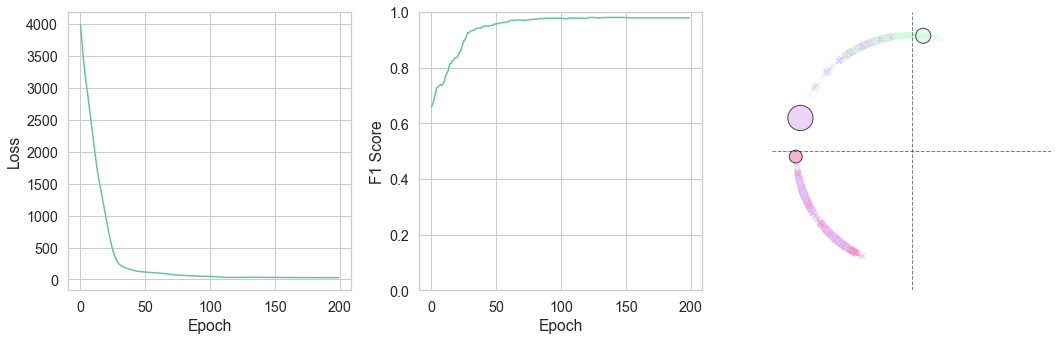

In [10]:
# define model, loss & optimizer
model = SiMaC(
    capacities=toy.items_capacities,
    n_users=toy.n_users,
    epsilon=0.05,
    alpha=distance_weight,
    n_features=n_features,
    user_embeddings=torch.FloatTensor(toy.users_features),
    train_user_embeddings=False
)

a = torch.ones(toy.n_users)
b = torch.FloatTensor(toy.items_capacities).view(-1)

sinkhorn_loss = SinkhornLoss(
    a=a,
    b=b,
    epsilon=0.05, 
    solver=sinkhorn,
    n_iter=100
)

optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())

n_epochs = 200

#########
# Train #
#########

model.train()

stats = []

for epoch in range(n_epochs):
    train_epoch_loss = 0
    optimizer.zero_grad()

    # Model out
    M = model(toy.users_tensor, toy.items_tensor, toy.D_tensor)
    
    # Loss
    loss = sinkhorn_loss(M, target)
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        P = sinkhorn(M, a, b, 0.05, 100)
    
    # Predictions
    y_pred = assign_with_lap(P, toy.items_capacities)
    f1 = f1_score(y_true=toy.y_true_tensor, y_pred=y_pred, average="macro")
    
    # Print stats
    # print("Epoch {0}: loss={1:3f}, F1={2:.3f}".format(epoch+1, loss.item(), f1))
    stats.append([loss.item(), f1])

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

########
# Plot #
########

# Loss
sns.lineplot(
    x=range(n_epochs),
    y=[s[0] for s in  stats],
    ax=axs[0]
)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")

# F1 Score
sns.lineplot(
    x=range(n_epochs),
    y=[s[1] for s in  stats],
    ax=axs[1]
)
axs[1].set_ylim(0, 1)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("F1 Score")

# Embeddings
viz.plot_embeddings(
    users_features=model.user_embeddings.weight,
    items_features=model.item_embeddings.weight,
    items_capacities=toy.items_capacities,
    y_pred=y_pred,
    ax=axs[2]
)

plt.tight_layout()
plt.show()